# Seminar 3 Part 3: Deep Q Networks Methods

# Deep Q-Networks (DQN)

![](graphs/dqn_benchmarks.png)


This exercise aims to replicate the results from the paper [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) published in Nature. This paper develops a DQN that can learn successful policy directly from high-dimensional inputs using end-to-end reinforcement learning. The original DQN algorithm is implemented on the Atari games. Note that as training for Breakout takes many hours we will not be able to analyze the results in class. As such, we will implement the algorithm on LunarLander instead. 

We first review the DQN algorithm. 

### Basic ideas of DQN

The $Q$ function for Deep Q-Networks is approximated by a neural network architecture

![](graphs/neural_network.png)

#### Experience replay via minibatches

Recall that past state-action-reward tuples are stored in a memory. Random samples are collected to form minibatches on which the parameter updates (e.g. via Stochastic Gradient Descent) are computed. The size of the minibatches trades of a strong variance (too few samples) and computational cost (too many samples)

<img src="graphs/minibatch.png" alt="Drawing" style="width: 750px;"/>
<img src="graphs/experience_replay.png" alt="Drawing" style="width: 750px;"/>

#### Using two cloned networks - Policy and Target Networks

![](graphs/target_network.png)

A source that may cause instability is the correlation between the estimates of the action-value function and the target. 
For example, the DQN loss function at iteration $t$ is defined as

$$\mathcal{L}_t(\theta_t)=\mathbb{E}_{(s,a,r,s'){\sim}U(D)}[(r+{\gamma}\max_{a'}\hat{Q}(s',a';\theta_t)-\hat{Q}(s,a;\theta_t))^2]$$

where $r+{\gamma}\max_{a'}\hat{Q}(s',a';\theta_t)$ is the Q-learning target. 
In DQN, both $Q(s',a';\theta_t)$ that estimates the Q-learning target and 
$Q(s,a;\theta_t)$ that generates actions are parametrised using convolutional neural 
networks where $\theta$ are the network parameters. 
The network that estimates the Q-learning target is usually called *target network* and the one that generates actions is called *policy network*. 

DQN stabilies learning by freezing the target network, i.e., 

$$\mathcal{L}_t(\theta_t)=\mathbb{E}_{(s,a,r,s'){\sim}U(D)}[(r+{\gamma}\max_{a'}\hat{Q}(s',a';\theta_t^{-})-\hat{Q}(s,a;\theta_t))^2].$$

During training, the policy network parameters $\theta_t$ 
are updated per time step, while the target network parameters $\theta_t^{-}$ are only updated every $T_{\textrm{target}}$ steps. 

### Lunar Lander

> The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.
Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.
Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.
Solved is 200 points.
Landing outside the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt. Please see the [source code](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py) for details.

<img src="graphs/lunar_lander.png" alt="Drawing" style="width: 500px;"/>

We will use `PyTorch` to implement the DQN algorithm. To install PyTorch via Anaconda, use the following conda command:

`conda install pytorch torchvision -c pytorch`

You also need to install gym [Box2D](https://www.gymlibrary.dev/environments/box2d/). Try

`pip install swig`

`pip install torch torchvision torchaudio`

`pip install box2d pygame`

`pip install box2d box2d-kengz`

The code below is from this [notebook](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-05-07-DQN-LunarLander.ipynb). 

We first import some necessary packages. 

In [1]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

We next initialize the environment.

In [2]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


We next define the neural network architecture. We consider neural networks with 2 hidden layers, 64 nodes per layer and ReLU activation function. The output layer produces the Q-values under all actions. 

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

We next define some hyperparameters. 

In [4]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# See more information about CUBA https://developer.nvidia.com/cuda-zone#:~:text=CUDA%C2%AE%20is%20a%20parallel,harnessing%20the%20power%20of%20GPUs.

We next define the agent class.

In [5]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        # https://stackoverflow.com/questions/62261793/what-happens-when-we-call-cpu-data-numpy-on-a-pytorch-tensor
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

The soft update is used to improve the stability. See this [post](https://ai.stackexchange.com/questions/21485/how-and-when-should-we-update-the-q-target-in-deep-q-learning). We next define the replay buffer.

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Notice that we use deque here to store the data. deque is very similar to list. It is preferred over a list in the cases where we need quicker append and pop operations from both the ends of the container, as deque provides an O(1) time complexity for append and pop operations as compared to list which provides O(n) time complexity. In addition, if the number of items in the input iterable is greater than buffer size, then deque discards the left-most items.

Next, we train the DQN agent. Again the tradeoff is between performance and running time. The current parameters solve the environment and training runs for about 20 minutes.

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        state = state[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -164.97
Episode 200	Average Score: -152.18
Episode 300	Average Score: -55.790
Episode 400	Average Score: 5.0853
Episode 500	Average Score: 125.13
Episode 566	Average Score: 200.55
Environment solved in 466 episodes!	Average Score: 200.55


Finally, we plot the scores and visualize the optimal policy. 

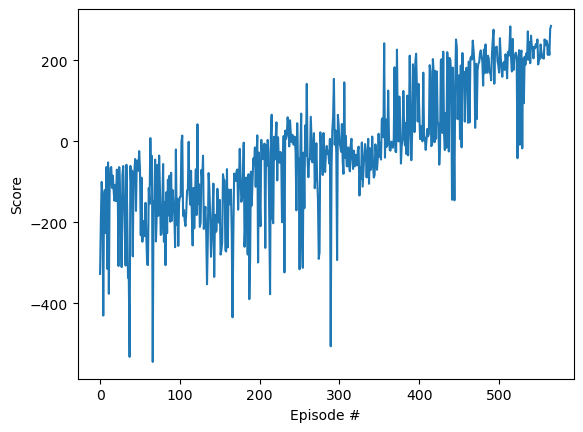

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()